# Filters

A demonstration of filter and filter collections creation and usage.

In [1]:
import numpy as np
from synthesizer.filters import Filter, FilterCollection, UVJ

Define some wavelengths (in A) over which we want to define our filters

In [17]:
lams = np.linspace(2000, 55000, 1000)

Define an individual filter from SVO

In [4]:
filt = Filter("JWST/NIRCam.F200W", new_lam=lams)

And define a fake transmission curve

In [5]:
trans = np.zeros(lams.size)
trans[int(lams.size / 4): int(lams.size / 2)] = 1

You can either define a FilterCollection from a single filter type

In [6]:
fs = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
fc1 = FilterCollection(filter_codes=fs, new_lam=lams)

... or a mixture, assuming the wavelengths are in the same unit system.

In [7]:
fs = [f"JWST/NIRCam.{f}" for f in ["F090W", "F250M"]]
tophats = {
    "U": {"lam_eff": 3650, "lam_fwhm": 660},
    "V": {"lam_eff": 5510, "lam_fwhm": 880},
    "J": {"lam_eff": 12200, "lam_fwhm": 2130},
}
generics = {"filter1": trans}
fc2 = FilterCollection(
    filter_codes=fs, tophat_dict=tophats, generic_dict=generics, new_lam=lams
)

You can get the length of a FilterCollection.

In [9]:
print("We have %d filters" % len(fc2))

We have 6 filters


Loop over it as if it were a list.

In [10]:
print("My Filters:")
for f in fc2:
    print(f.filter_code)

My Filters:
JWST/NIRCam.F090W
JWST/NIRCam.F250M
U
V
J
filter1


Compare FilterCollections.

In [11]:
if fc2 == fc2:
    print("This is the same filter collection!")
if fc2 != fc1:
    print("These are not the same filter collection!")

This is the same filter collection!
These are not the same filter collection!


Add filters to simply combine filter collections and individual filters

In [13]:
fc = fc1 + filt
fc += fc2

Print out the new filter codes

In [14]:
print("My combined Filters:", fc.filter_codes)

My combined Filters: ['JWST/NIRCam.F070W', 'JWST/NIRCam.F444W', 'JWST/NIRCam.F200W', 'JWST/NIRCam.F090W', 'JWST/NIRCam.F250M', 'U', 'V', 'J', 'filter1']


You can even easily plot the transmission curves with a helper method

(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='$\\rm \\lambda/\\AA$', ylabel='$\\rm T_{\\lambda}$'>)

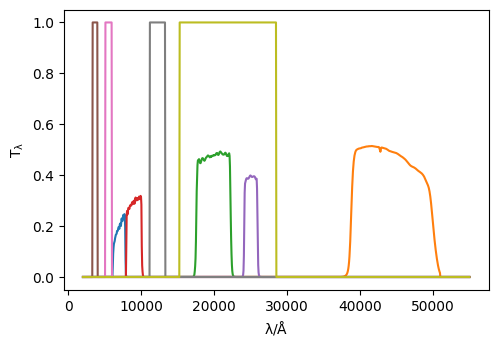

In [15]:
fc.plot_transmission_curves()

There's also a helper function to create the above UVJ filter set.

(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='$\\rm \\lambda/\\AA$', ylabel='$\\rm T_{\\lambda}$'>)

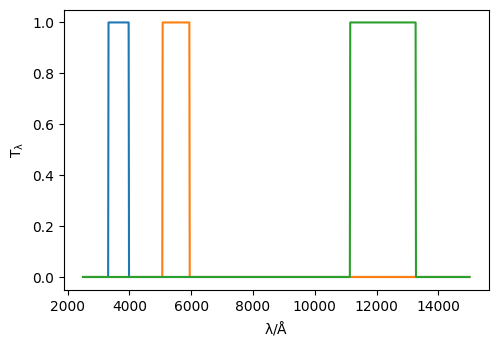

In [19]:
lams = np.linspace(2500, 15000, 1000)
fc = UVJ(new_lam=lams)
fc.plot_transmission_curves()